In [6]:
# --- Single-image classification in a notebook (DenseNet121-based) ---

import io
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets

import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model


# Optional: quieter TF logs
tf.get_logger().setLevel('ERROR')


# Instantiate the classifier
classifier = load_model("classifier.h5")

def prepare_image_for_model(file_bytes, target_size=(64, 64)):
    """Load, RGB-convert, resize, and preprocess for DenseNet121."""
    img = Image.open(io.BytesIO(file_bytes)).convert("RGB")
    img_resized = img.resize(target_size, Image.BILINEAR)
    arr = np.asarray(img_resized, dtype=np.float32)
    arr = preprocess_input(arr)          # ImageNet-style normalization
    batch = np.expand_dims(arr, axis=0)  # Add batch dimension
    return img, batch  # return original PIL image for display, and preprocessed batch

def classify_uploaded_image(file_bytes):
    img_display, batch = prepare_image_for_model(file_bytes)
    preds = classifier.predict(batch, verbose=0)[0]  # shape (2,)
    pred_idx = int(np.argmax(preds))
    pred_label = CLASS_NAMES[pred_idx]
    return img_display, pred_label, preds

# ---- Simple notebook UI with ipywidgets ----
uploader = widgets.FileUpload(accept='image/*', multiple=False)
run_btn = widgets.Button(description='Classify Image', button_style='primary')
out = widgets.Output()

def on_click_run(_):
    with out:
        clear_output()
        if not uploader.value:
            print("Please upload one image first.")
            return

        files = uploader.value
        # Handle ipywidgets versions: dict (old), tuple/list (new)
        if isinstance(files, dict):
            file_info = next(iter(files.values()))
        elif isinstance(files, (tuple, list)):
            file_info = files[0]
        else:
            raise TypeError(f"Unsupported FileUpload.value type: {type(files)}")

        file_bytes = file_info["content"]

        img, label, probs = classify_uploaded_image(file_bytes)

        print("Prediction:", label)
        print(f"Probabilities -> {CLASS_NAMES[0]}: {probs[0]:.4f}, {CLASS_NAMES[1]}: {probs[1]:.4f}")
        display(img)

run_btn.on_click(on_click_run)

display(widgets.VBox([widgets.HTML("<b>Upload one image, then click Classify:</b>"),
                       uploader, run_btn, out]))




In [4]:
classifier.save("classifier.keras")

In [10]:
# Load the entire model (architecture + weights)
classifier = load_model("/Users/sambra/Documents/GitHub/sam_based_fungal_app/classifier.keras")
path_input = "/Users/sambra/Documents/GitHub/sporecounting/Segmented_Images/original/Wt 8h OH RB2_C00_ORG_ (1)_7.png"


Prediction: Germinated
Ungerminated: 0.0001
Germinated: 0.9999


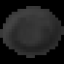

In [11]:
# --- Single-image classification from a file path (DenseNet121-based) ---

from pathlib import Path
import numpy as np
from PIL import Image
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model

# ==== Set this ====
IMAGE_PATH = "/Users/sambra/Documents/GitHub/sporecounting/Segmented_Images/original/Wt 8h OH RB2_C00_ORG_ (1)_7.png"   # <-- put your image path here
MODEL_PATH = "/Users/sambra/Documents/GitHub/sam_based_fungal_app/classifier.keras"       # change if needed
CLASS_NAMES = ["Ungerminated", "Germinated"]  # adjust to your classes

# Optional: quieter TF logs
tf.get_logger().setLevel("ERROR")

# Load model
classifier = load_model(MODEL_PATH)

def prepare_image_from_path(path: str, target_size=(64, 64)):
    """Load file path -> RGB -> resize -> preprocess -> return (PIL image, batch)."""
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Image path not found: {p}")

    img = Image.open(p).convert("RGB")
    img_resized = img.resize(target_size, Image.BILINEAR)
    arr = np.asarray(img_resized, dtype=np.float32)
    arr = preprocess_input(arr)                    # ImageNet-style normalization
    batch = np.expand_dims(arr, axis=0)           # (1, H, W, 3)
    return img, batch

def classify_image_path(path: str):
    img_display, batch = prepare_image_from_path(path)
    preds = classifier.predict(batch, verbose=0)[0]   # shape (num_classes,)
    pred_idx = int(np.argmax(preds))
    pred_label = CLASS_NAMES[pred_idx]
    return img_display, pred_label, preds

# Run classification
img, label, probs = classify_image_path(IMAGE_PATH)
print("Prediction:", label)
for i, name in enumerate(CLASS_NAMES):
    print(f"{name}: {probs[i]:.4f}")
display(img)
